## Homework1

Metin Abadan - 19050111015


Sertac İnce - 20050111003

In [1]:
import numpy as np
import torch

In [2]:
np.random.seed(24)

### Creating Dataset

In [3]:
def createDataset(slope, distance, nSample):
    #sampleProportion: feature 1 / feature 2, between 0 and 1
    xrange = 30
    distribute = 40
    line_space = 10
    corruption = -7 #to shift line
    misclass = 15
    
    x1 = np.random.randn(nSample) * xrange + np.sqrt(distance)

    distribution = np.random.randn(nSample) * distribute #to extend from line
    distribution += corruption #shifts line to corrupt data sample numbers
    distribution = np.sign(distribution) * line_space + distribution #to make a space between classes

    x2 = np.sqrt(distance) + x1 * slope + distribution
    y = np.where(np.sqrt(distance) + x1 * slope + np.random.randn(nSample) * misclass > x2, 1, -1) #for making misclassifications 
    
    return np.column_stack((np.ones((nSample, 1)), x1, x2)), y

In [4]:
slope = -0.8
distance = 50
nSample = 100

w_initial = torch.zeros(3)

X, y = createDataset(slope, distance, nSample)


In [5]:
import matplotlib.pyplot as plt
%matplotlib inline

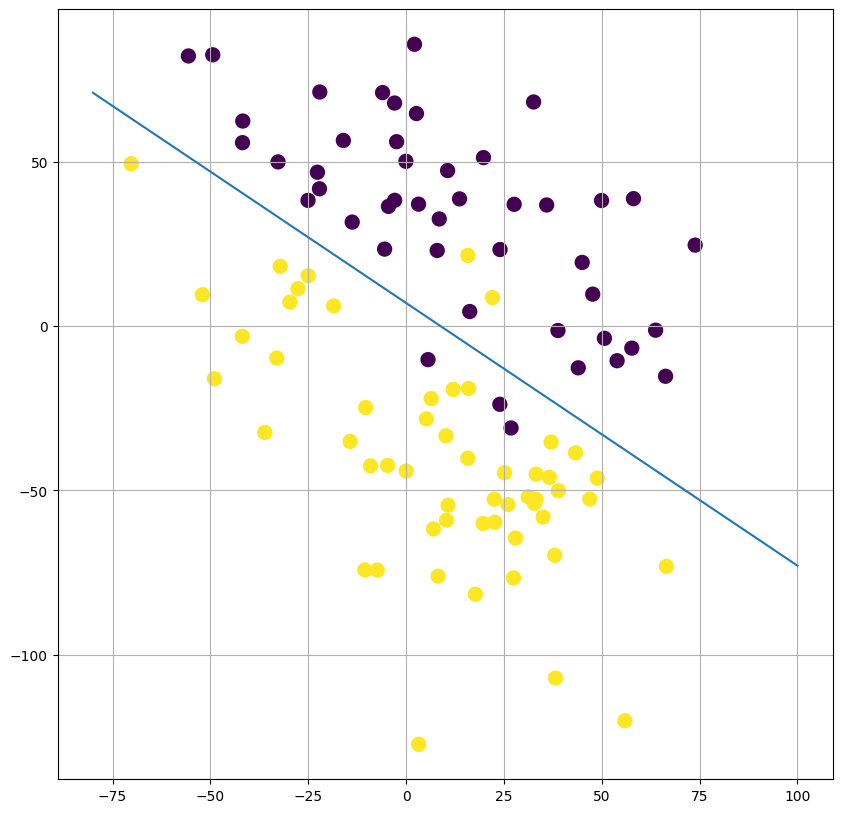

In [6]:
plt.figure(figsize=(10,10))
plt.scatter(X[:,1], X[:,2], c=y, linewidths=5)
plt.plot([-80,100], np.sqrt(distance) + np.array([-80,100]) * slope)
plt.grid()
plt.show()

#### Decision boundary plotter function

In [7]:
def draw_decision_boundary(w, x1a, x1b):
    # m = -w1 / 2
    m = -w[1] / w[2]

    # c = -w0 / w2
    c = -w[0] / w[2]
    
    # y = mx + c,  
    x2a = m * x1a + c
    x2b = m * x1b + c
    
    plt.plot([x1a, x1b], [x2a, x2b])

In [8]:
# Convert numpy arrays to tensors
X = torch.from_numpy(X).float()
y = torch.from_numpy(y).float()

#### Quantize Function

In [9]:
quantize = lambda X, w : torch.tensor(np.where(X.matmul(w) > 0.0, 1, -1))

In [10]:
quantize2 = lambda x : torch.tensor(np.where(x > 0.0, 1, -1))

#### Error Function

In [11]:
def error(X, y, w):
    
    y_hat = X.matmul(w)
    
    r = y_hat - y
    
    mse = 0.5 * torch.square(r).mean()
    
    return mse

### Activation Functions

In [12]:
def linear(out):
    return out

In [13]:
def sigmoid(out):
    return 1 / (1+torch.exp(-out))

In [14]:
def tanh(out):
    x_exp, neg_x_exp = torch.exp(out), torch.exp(-out)
    return (x_exp - neg_x_exp) / (x_exp + neg_x_exp)

In [15]:
def ReQU(out):
    return (out**2) / (1 + torch.exp(-out))

### Sequential Gradient Descent

In [16]:
def sequential_gradient_descent(X:torch.tensor, y:torch.tensor, w:torch.tensor, learning_rate, iteration, act_func):
    costList = []
    accuracy = []
    w.requires_grad = True
    # First error calculation 
    errors = error(X, y, w)
    costList.append(errors)
    with torch.no_grad():
        accuracy.append(accuracy_score(y, quantize2(act_func(X.matmul(w))))) 

    for i in range(iteration):
    
        e = error(X, y, w)
        e.backward(retain_graph=True)
      
        with torch.no_grad():
            w.sub_(learning_rate * w.grad)  # Sequential part 
          
            costList.append(e.detach().item())
            accuracy.append(accuracy_score(y, quantize2(act_func(X.matmul(w)))))
            
        w.grad.zero_()
  
    w_best = w.clone()
    number_of_epochs = (i + 1) / nSample   
        
    return accuracy, costList, w_best, number_of_epochs 

In [17]:
from sklearn.metrics import accuracy_score

In [18]:
iteration = 500
learning_rate = 1e-5
# Change activation function
act_func = tanh

acc, cost, w_seq, number_of_epochs = sequential_gradient_descent(X, y, w_initial, learning_rate, iteration, act_func)

print("Number of epochs : ", number_of_epochs)

Number of epochs :  5.0


In [19]:
#convert cost to a tensor
cost = torch.tensor(cost)

### Plotting Loss

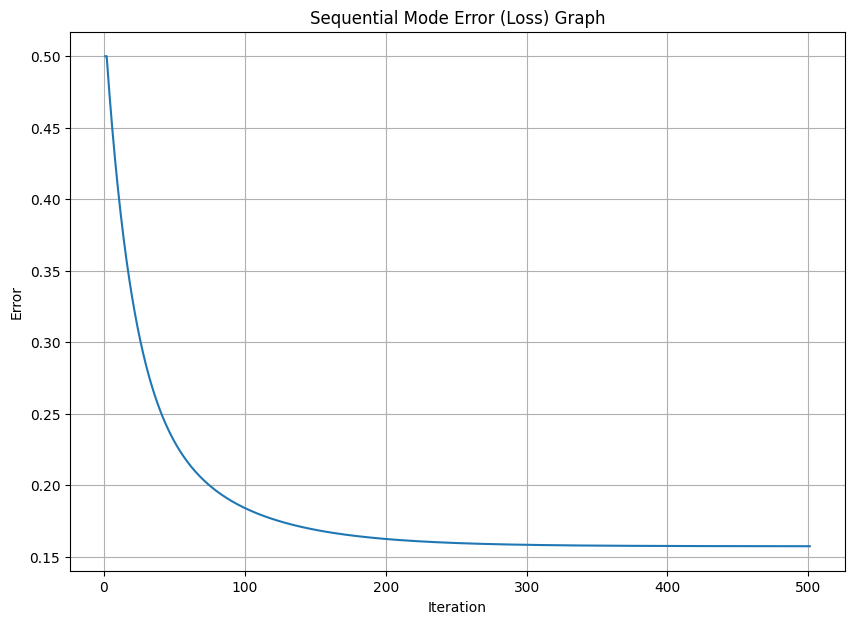

In [20]:
plt.figure(figsize=(10,7))
plt.plot(range(1,502), cost.detach().numpy())
plt.xlabel("Iteration")
plt.ylabel("Error")
plt.title("Sequential Mode Error (Loss) Graph")
plt.grid()
plt.show()

### Plotting Accuracy

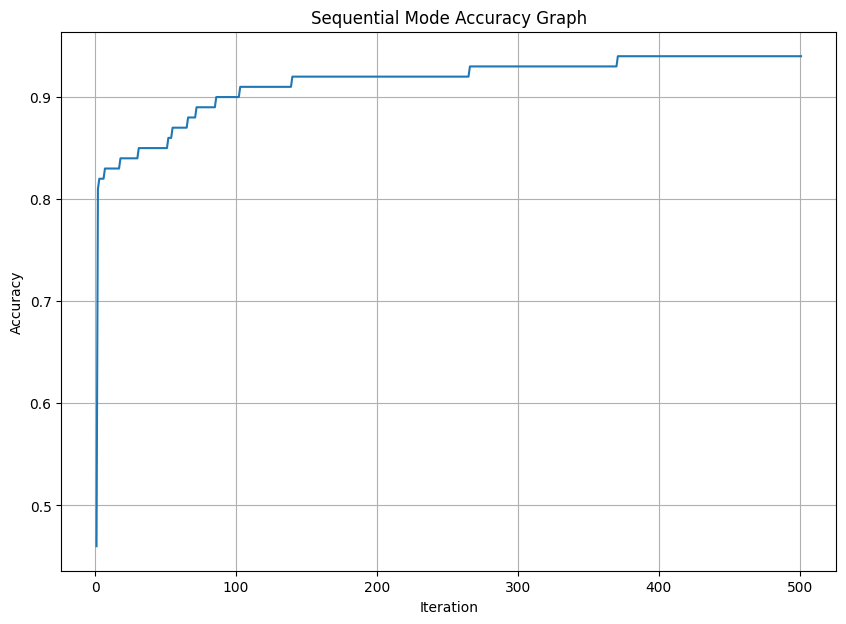

In [21]:
plt.figure(figsize=(10,7))
plt.plot(range(1,502), acc)
plt.xlabel("Iteration")
plt.ylabel("Accuracy")
plt.title("Sequential Mode Accuracy Graph")
plt.grid()
plt.show()

In [22]:
y_hat_seq = quantize2(act_func(X.matmul(w_seq)))
print("Trained accuracy :", accuracy_score(y, y_hat_seq))

Trained accuracy : 0.94


### Slope After Training

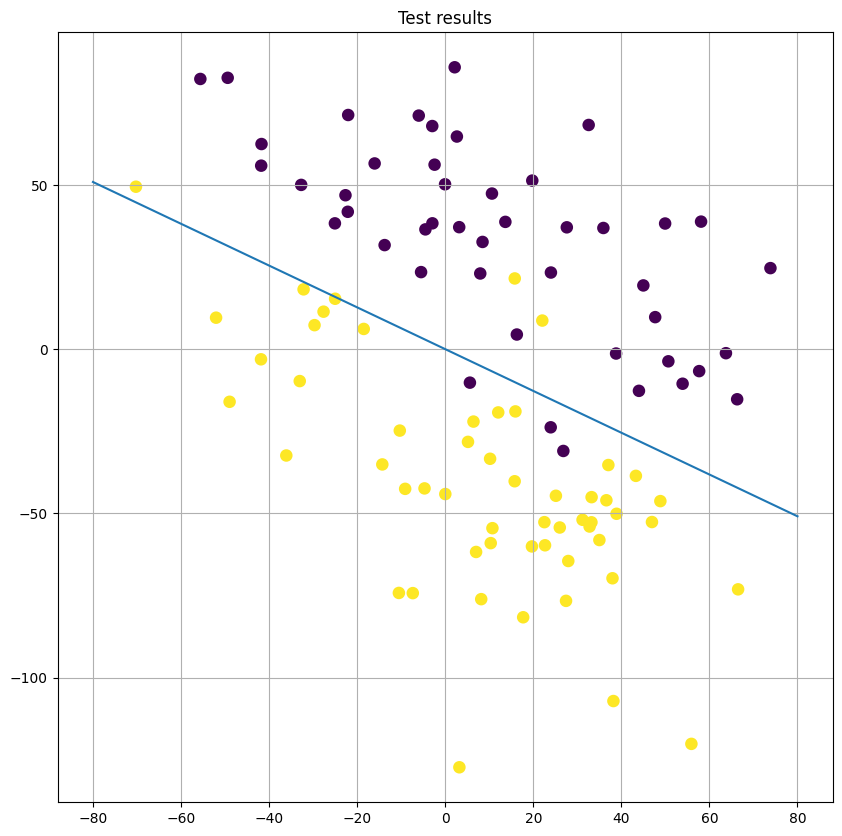

In [23]:
plt.figure(figsize=(10,10))
draw_decision_boundary(w_seq.detach().numpy(), -80, 80)
plt.scatter(X[:,1], X[:,2], c=y, linewidths=3)
plt.title("Test results")
plt.grid()
plt.show()